# scFates - Tree analysis

ref: https://scfates.readthedocs.io/en/latest/Tree_Analysis_Bone_marrow_fates.html

# Set up

In [10]:
#Sets the 'R_HOME' environment variable to the location where Conda installed R libraries.
#You should run this code at the beginning of your Jupyter notebook, before importing any modules that rely on rpy2 or scFates.
#This will set the 'R_HOME' environment variable for the duration of your Python session
import os, sys
os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"
import scFates

In [11]:
import sys
!{sys.executable} -m pip -q install palantir fa2

In [12]:
from anndata import AnnData
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import palantir
import matplotlib.pyplot as plt
import glob

sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout
## fix palantir breaking down some plots
import seaborn
seaborn.reset_orig()
%matplotlib inline
import os

import warnings
warnings.filterwarnings('ignore')

sc.set_figure_params()
scf.set_figure_pubready()

In [13]:
import session_info
session_info.show()

In [14]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map = 'RdPu',figsize=(4,4))

In [15]:
from datetime import datetime

today = datetime.today().strftime('%Y-%m-%d')
print(today)

2023-10-24


# Functions

In [16]:
def plot_and_store(init_pos, adata):
    """
    This function selects the columns of the obsm layer specified by init_pos, 
    draws a graph using these coordinates as the initial positions, and stores the graph 
    coordinates in a new obsm layer named 'X_draw_graph_fa_' followed by the value of init_pos. 
    The modified AnnData object is then returned.

    If adata.obsm[f'X_draw_graph_fa_{init_pos}'] already exists, it puts that in adata.obsm['X_draw_graph_fa'].
    If adata.obsm[f'X_draw_graph_fa_{init_pos}'] does not exist, it performs sc.tl.draw_graph() as before.

    Parameters
    ----------
    init_pos : str
        Initial position for the graph. Should be in the format 'X_palantir12'.
    
    adata : AnnData
        The annotated data matrix of shape n_obs x n_vars. Rows correspond
        to cells and columns to genes.

    Returns
    -------
    adata : AnnData
        The modified annotated data matrix.
    """
    x_col = int(init_pos[-2:][0]) - 1
    y_col = int(init_pos[-2:][1]) - 1
    selected_cols = [x_col, y_col]
    adata.obsm[f'{init_pos}'] = adata.obsm[f'{init_pos[:-2]}'][:,selected_cols]
    
    if f'X_draw_graph_fa_{init_pos}' in adata.obsm:
        print(f'graph using {init_pos} has previously been calculated, retrieving that...')
        adata.obsm['X_draw_graph_fa'] = adata.obsm[f'X_draw_graph_fa_{init_pos}']
    else:
        print('calculating graph coordinates...')
        sc.tl.draw_graph(adata,init_pos=init_pos)
        adata.obsm[f'X_draw_graph_fa_{init_pos}'] = adata.obsm['X_draw_graph_fa'].copy()
    return adata

In [17]:
def plot_embedding(
    adata,
    groupby,
    basis="umap",
    color=None,
    annot=True,
    min_group_size=0,
    greyout_group=None,
    highlight_group=None,
    size=None,
    use_uns_colors=True,
    save=None,
    savedpi=300,
    figsize=(4, 4),
    **kwargs,
):
    set_figsize(figsize)
    if f"X_{basis}" not in adata.obsm.keys():
        raise KeyError(f'"X_{basis}" not found in `adata.obsm`.')
    if min_group_size:
        group_sizes = adata.obs[groupby].value_counts()
        good_groups = group_sizes[group_sizes >= min_group_size].index
        adata = adata[adata.obs[groupby].isin(good_groups)].copy()
    if isinstance(groupby, (list, tuple)):
        groupby = groupby[0]
    if groupby not in adata.obs.columns:
        raise KeyError(f'"{groupby}" not found in `adata.obs`.')
    if adata.obs[groupby].dtype.name != "category":
        if (
            isinstance(adata.obs[groupby][0], (str, bool, np.bool_))
            and adata.obs[groupby].unique().size < 100
        ):
            adata.obs[groupby] = adata.obs[groupby].astype(str).astype("category")
        else:
            sc_warn(f'"{groupby}" is not categorical.')
            plot_scatter(adata, basis=basis, color=groupby, **kwargs)
    categories = list(adata.obs[groupby].cat.categories)
    rename_dict1 = {
        ct: f"{i:^5d} {ct} (n={(adata.obs[groupby]==ct).sum()})" for i, ct in enumerate(categories)
    }
    restore_dict1 = {
        f"{i:^5d} {ct} (n={(adata.obs[groupby]==ct).sum()})": ct for i, ct in enumerate(categories)
    }
    rename_dict2 = {ct: f"{i:^5d} {ct}" for i, ct in enumerate(categories)}
    restore_dict2 = {f"{i:^5d} {ct}": ct for i, ct in enumerate(categories)}

    marker_size = size
    kwargs["show"] = False
    kwargs["save"] = False
    kwargs["frameon"] = kwargs.get("frameon", None)
    kwargs["legend_loc"] = kwargs.get("legend_loc", "right margin")

    if color is not None and color != groupby:
        use_uns_colors = False
    color = groupby if color is None else color
    offset = 0 if "diffmap" in basis else -1
    xi, yi = 1, 2
    if "components" in kwargs:
        xi, yi = kwargs["components"]
    xi += offset
    yi += offset

    if not (use_uns_colors and f"{color}_colors" in adata.uns):
        adata.uns[f"{color}_colors"] = make_palette(
            adata.obs[color].cat.categories.size, kwargs.get("palette", None)
        )
        if greyout_group is not None:
            if isinstance(greyout_group, str):
                greyout_group = [greyout_group]
            greyout_indices = np.where(
                adata.obs[color].cat.categories.isin(greyout_group)
            )[0]
            for nan_i in greyout_indices:
                adata.uns[f"{color}_colors"][nan_i] = "#E0E0E0"

        if highlight_group is not None:
            if isinstance(highlight_group, str):
                highlight_group = [highlight_group]
            nohl_indices = np.where(
                ~adata.obs[color].cat.categories.isin(highlight_group)
            )[0]
            for nohl_i in nohl_indices:
                adata.uns[f"{color}_colors"][nohl_i] = "#E0E0E0"

    if annot == "full":
        adata.obs[groupby].cat.rename_categories(rename_dict1, inplace=True)
    elif annot in (None, False, "none"):
        kwargs["title"] = ""
        kwargs["legend_loc"] = None
    else:
        adata.obs[groupby].cat.rename_categories(rename_dict2, inplace=True)

    try:
        if "ax" in kwargs:
            ax = kwargs["ax"]
            plot_scatter(adata, basis=basis, color=color, size=marker_size, **kwargs)
        else:
            ax = plot_scatter(adata, basis=basis, color=color, size=marker_size, **kwargs)
    finally:
        if annot == "full":
            adata.obs[groupby].cat.rename_categories(restore_dict1, inplace=True)
        elif annot not in (None, False, "none"):
            adata.obs[groupby].cat.rename_categories(restore_dict2, inplace=True)
    if annot not in (None, False, "none"):
        centroids = pseudo_bulk(adata, groupby, use_rep=f"X_{basis}", FUN=np.median).T
        fontsize = kwargs["legend_fontsize"] if "legend_fontsize" in kwargs else 11
        texts = [
            ax.text(x=row[xi], y=row[yi], s=f"{i:d}", fontsize=fontsize - 1.5, fontweight="bold")
            for i, row in centroids.reset_index(drop=True).iterrows()
            if row[0].astype(str) != "nan"
        ]
        from adjustText import adjust_text

        adjust_text(texts, ax=ax, text_from_points=False, autoalign=False)
        version_scale = 1 if sc.__version__.startswith("1.4") else 1
        ax.legend(
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            frameon=False,
            ncol=int(np.ceil(len(categories) / int(figsize[1] * 3) / 8 * fontsize)),
            fontsize=fontsize * 1.1,
            markerscale=3 * (fontsize / 11) * version_scale,
            handletextpad=-1.9,
            labelspacing=9 / fontsize,
        )
    if save:
        plt.savefig(fname=save, dpi=savedpi, bbox_inches="tight", pad_inches=0.1)
    if "ax" not in kwargs:
        return ax

# Paths

In [18]:
# Parameters
job_name = "aCMs_WholeSample"
n_layers = 1
developing = False
paired_adata_path = "/lustre/scratch126/cellgen/team205/heart/objects/fetal/RNA/aCMs_WholeSample_paired.h5ad"
unimodality_adata_path = "none"
combination = "multivi_aCMs_WholeSample_n_layers1"


latent_variables_dir=os.path.join("/lustre/scratch126/cellgen/team205/heart/objects/fetal/RNA","latent_variables") # for latent variables
latent_variables_path=os.path.join(latent_variables_dir, f"mvi_{combination}_latent_variables.h5ad")

# Import adata

In [19]:
adata = sc.read(paired_adata_path)
adata

AnnData object with n_obs × n_vars = 5664 × 544641
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id'

In [20]:
latent_variables = sc.read(latent_variables_path)
latent_variables

AnnData object with n_obs × n_vars = 5664 × 20

In [21]:
latent_variables.shape

(5664, 20)

In [22]:
adata.obsm["X_multiVI"]=latent_variables.X
adata

AnnData object with n_obs × n_vars = 5664 × 544641
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id'
    obsm: 'X_multiVI'

In [23]:
sc.pp.neighbors(adata,use_rep="X_multiVI")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


In [24]:
sc.tl.umap(adata,min_dist=0.01,n_components=3)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


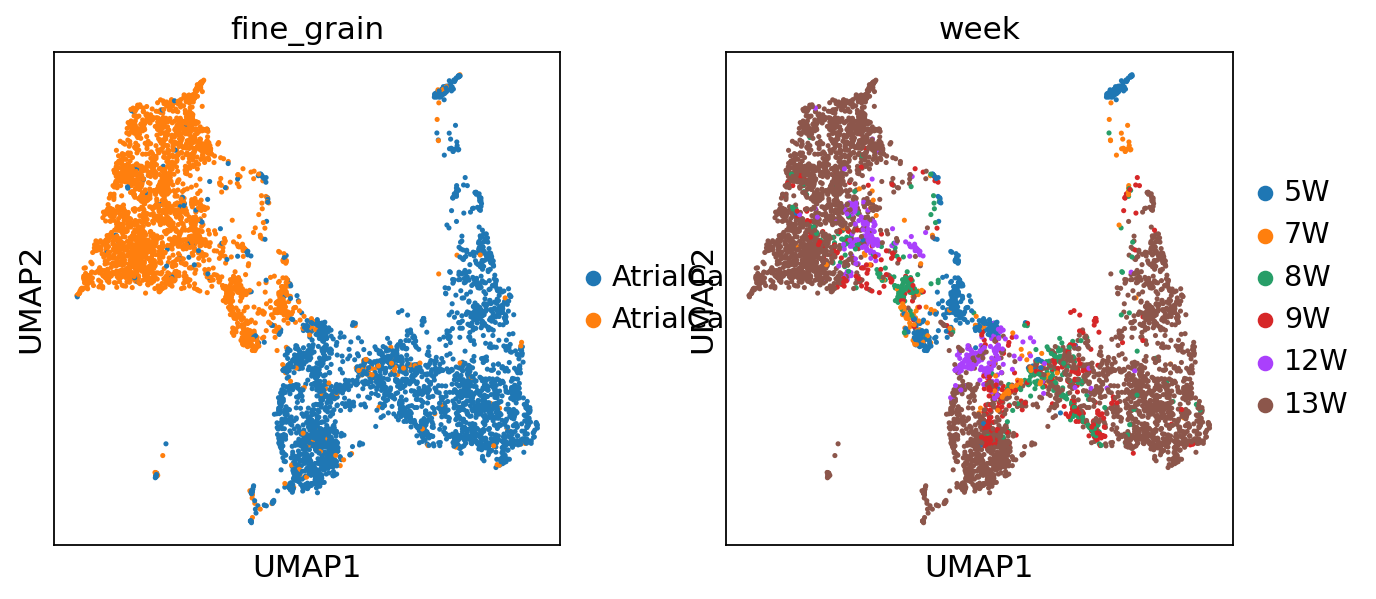

In [16]:
sc.pl.umap(adata,color=["fine_grain","week"])

In [17]:
adata

AnnData object with n_obs × n_vars = 5664 × 544641
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id'
    uns: 'neighbors', 'umap', 'fine_grain_colors', 'week_colors'
    obsm: 'X_multiVI', 'X_umap'
    obsp: 'distances', 'connectivities'

# Actual time - kNN smoothing

In [18]:
# Function to convert weeks to days
def week_to_days(week_str):
    # Extract the numerical part and convert to integer
    week_num = int(week_str.replace('W', ''))
    return week_num * 7

# Create a new column 'age_days' in adata.obs DataFrame
adata.obs['age_days'] = adata.obs['week'].apply(week_to_days)
adata.obs['age_days'] = adata.obs['age_days'].astype(float)
adata.obs['age_days'].value_counts()

91.0    3925
35.0     443
63.0     417
84.0     372
56.0     321
49.0     186
Name: age_days, dtype: int64

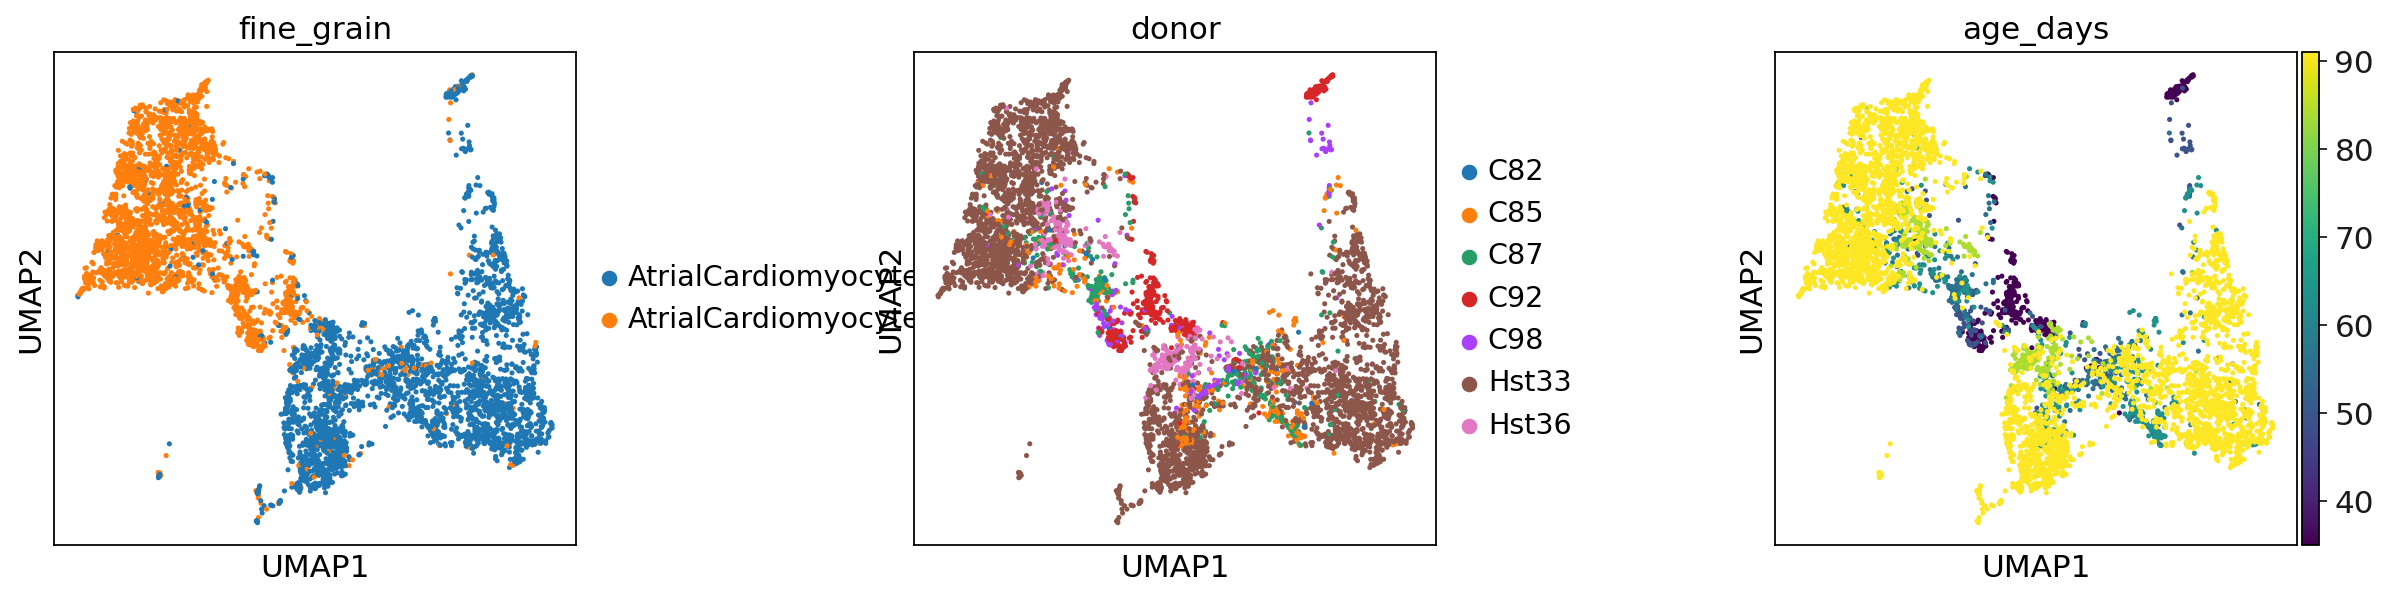

In [19]:
sc.pl.umap(adata,color=["fine_grain","donor","age_days"],cmap='viridis',wspace=0.5)

In [20]:

import scipy.sparse

column='age_days'

# Extract the key for the connectivities matrix
conn_key = adata.uns['neighbors']['connectivities_key']

# Now get the actual connectivities matrix using this key
conn_matrix = adata.obsp[conn_key]

# Convert age_days to a NumPy array
age_days = adata.obs[column].values

# Calculate the weighted sum of neighbors for each node
weighted_sum = conn_matrix.dot(age_days)

# Calculate the sum of weights for each node (including self)
sum_weights = conn_matrix.sum(axis=1).A1  # A1 returns a flattened ndarray

# Calculate the weighted average
age_days_smoothed = weighted_sum / sum_weights

# Add the smoothed values as a new column
adata.obs[f'{column}_smoothed_once'] = age_days_smoothed

In [21]:
# Min-max normalization
min_val = adata.obs['age_days'].min()
max_val = adata.obs['age_days'].max()
adata.obs['age_days_normalized'] = (adata.obs['age_days'] - min_val) / (max_val - min_val)

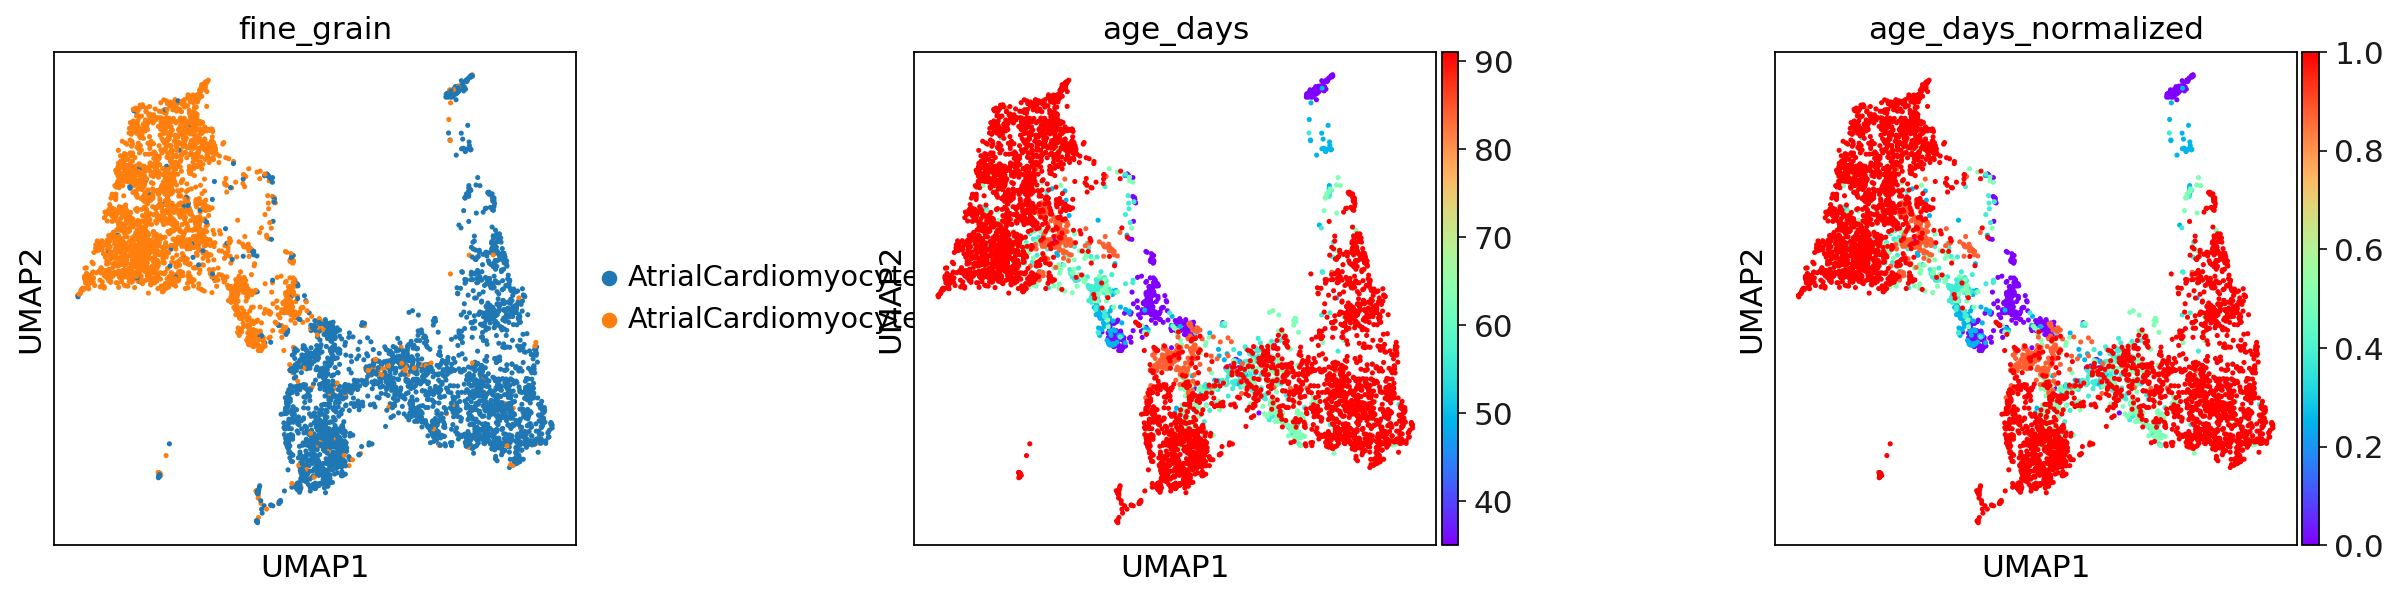

In [22]:
sc.pl.umap(adata,color=["fine_grain","age_days","age_days_normalized"],cmap='rainbow',wspace=0.5)

In [23]:
# Function to perform iterative smoothing until a stable state is achieved
def iterative_smoothing(adata, feature_col, tol=1e-10, max_iter=1000):
    # Extract the key for the connectivities matrix
    conn_key = adata.uns['neighbors']['connectivities_key']

    # Get the actual connectivities matrix using this key
    conn_matrix = adata.obsp[conn_key]

    # Convert feature to a NumPy array
    feature_values = adata.obs[feature_col].values

    # Initialize variables to keep track of previous and current state
    prev_values = feature_values.copy()
    iter_count = 0

    while iter_count < max_iter:
        # Calculate the weighted sum of neighbors for each node
        weighted_sum = conn_matrix.dot(feature_values)

        # Calculate the sum of weights for each node (including self)
        sum_weights = conn_matrix.sum(axis=1).A1  # A1 returns a flattened ndarray

        # Calculate the new feature values (weighted average)
        feature_values = weighted_sum / sum_weights

        # Check for convergence (within given tolerance)
        diff = np.abs(feature_values - prev_values).max()
        if diff < tol:
            print(f"Converged after {iter_count} iterations.")
            break

        # Update previous values for the next iteration
        prev_values = feature_values.copy()

        # Increment iteration count
        iter_count += 1

    # If maximum iterations reached
    if iter_count == max_iter:
        print(f"Max iterations reached. Last diff: {diff}")

    # Add the smoothed values as a new column
    new_col_name = f"{feature_col}_smoothed_iteratively"
    adata.obs[new_col_name] = feature_values

In [24]:
# Run the function

# Function to perform one round of smoothing on a given column of an AnnData object
def smooth_column_once(adata, column):
    """
    Smooths a given column in an AnnData object's obs DataFrame based on neighborhood graph.
    
    Parameters:
        adata (anndata.AnnData): The AnnData object containing the neighborhood graph and data.
        column (str): The column in the obs DataFrame to be smoothed.
    
    Returns:
        None: The AnnData object's obs DataFrame is modified in-place with the smoothed column.
    """
    # Extract the key for the connectivities matrix
    conn_key = adata.uns['neighbors']['connectivities_key']
    
    # Get the actual connectivities matrix using this key
    conn_matrix = adata.obsp[conn_key]
    
    # Convert the column values to a NumPy array
    column_values = adata.obs[column].values
    
    # Calculate the weighted sum of neighbors for each node
    weighted_sum = conn_matrix.dot(column_values)
    
    # Calculate the sum of weights for each node (including self)
    sum_weights = conn_matrix.sum(axis=1).A1  # A1 returns a flattened ndarray
    
    # Calculate the weighted average
    smoothed_values = weighted_sum / sum_weights
    
    # Add the smoothed values as a new column
    new_col_name = f"{column}_smoothed_once"
    adata.obs[new_col_name] = smoothed_values




In [25]:

smooth_column_once(adata,'age_days')
smooth_column_once(adata,'age_days_normalized')

tol=1e-6
max_iter=100000

iterative_smoothing(adata, 'age_days', tol=tol, max_iter=max_iter)
iterative_smoothing(adata, 'age_days_normalized', tol=1e-6, max_iter=max_iter)

Converged after 608 iterations.
Converged after 436 iterations.


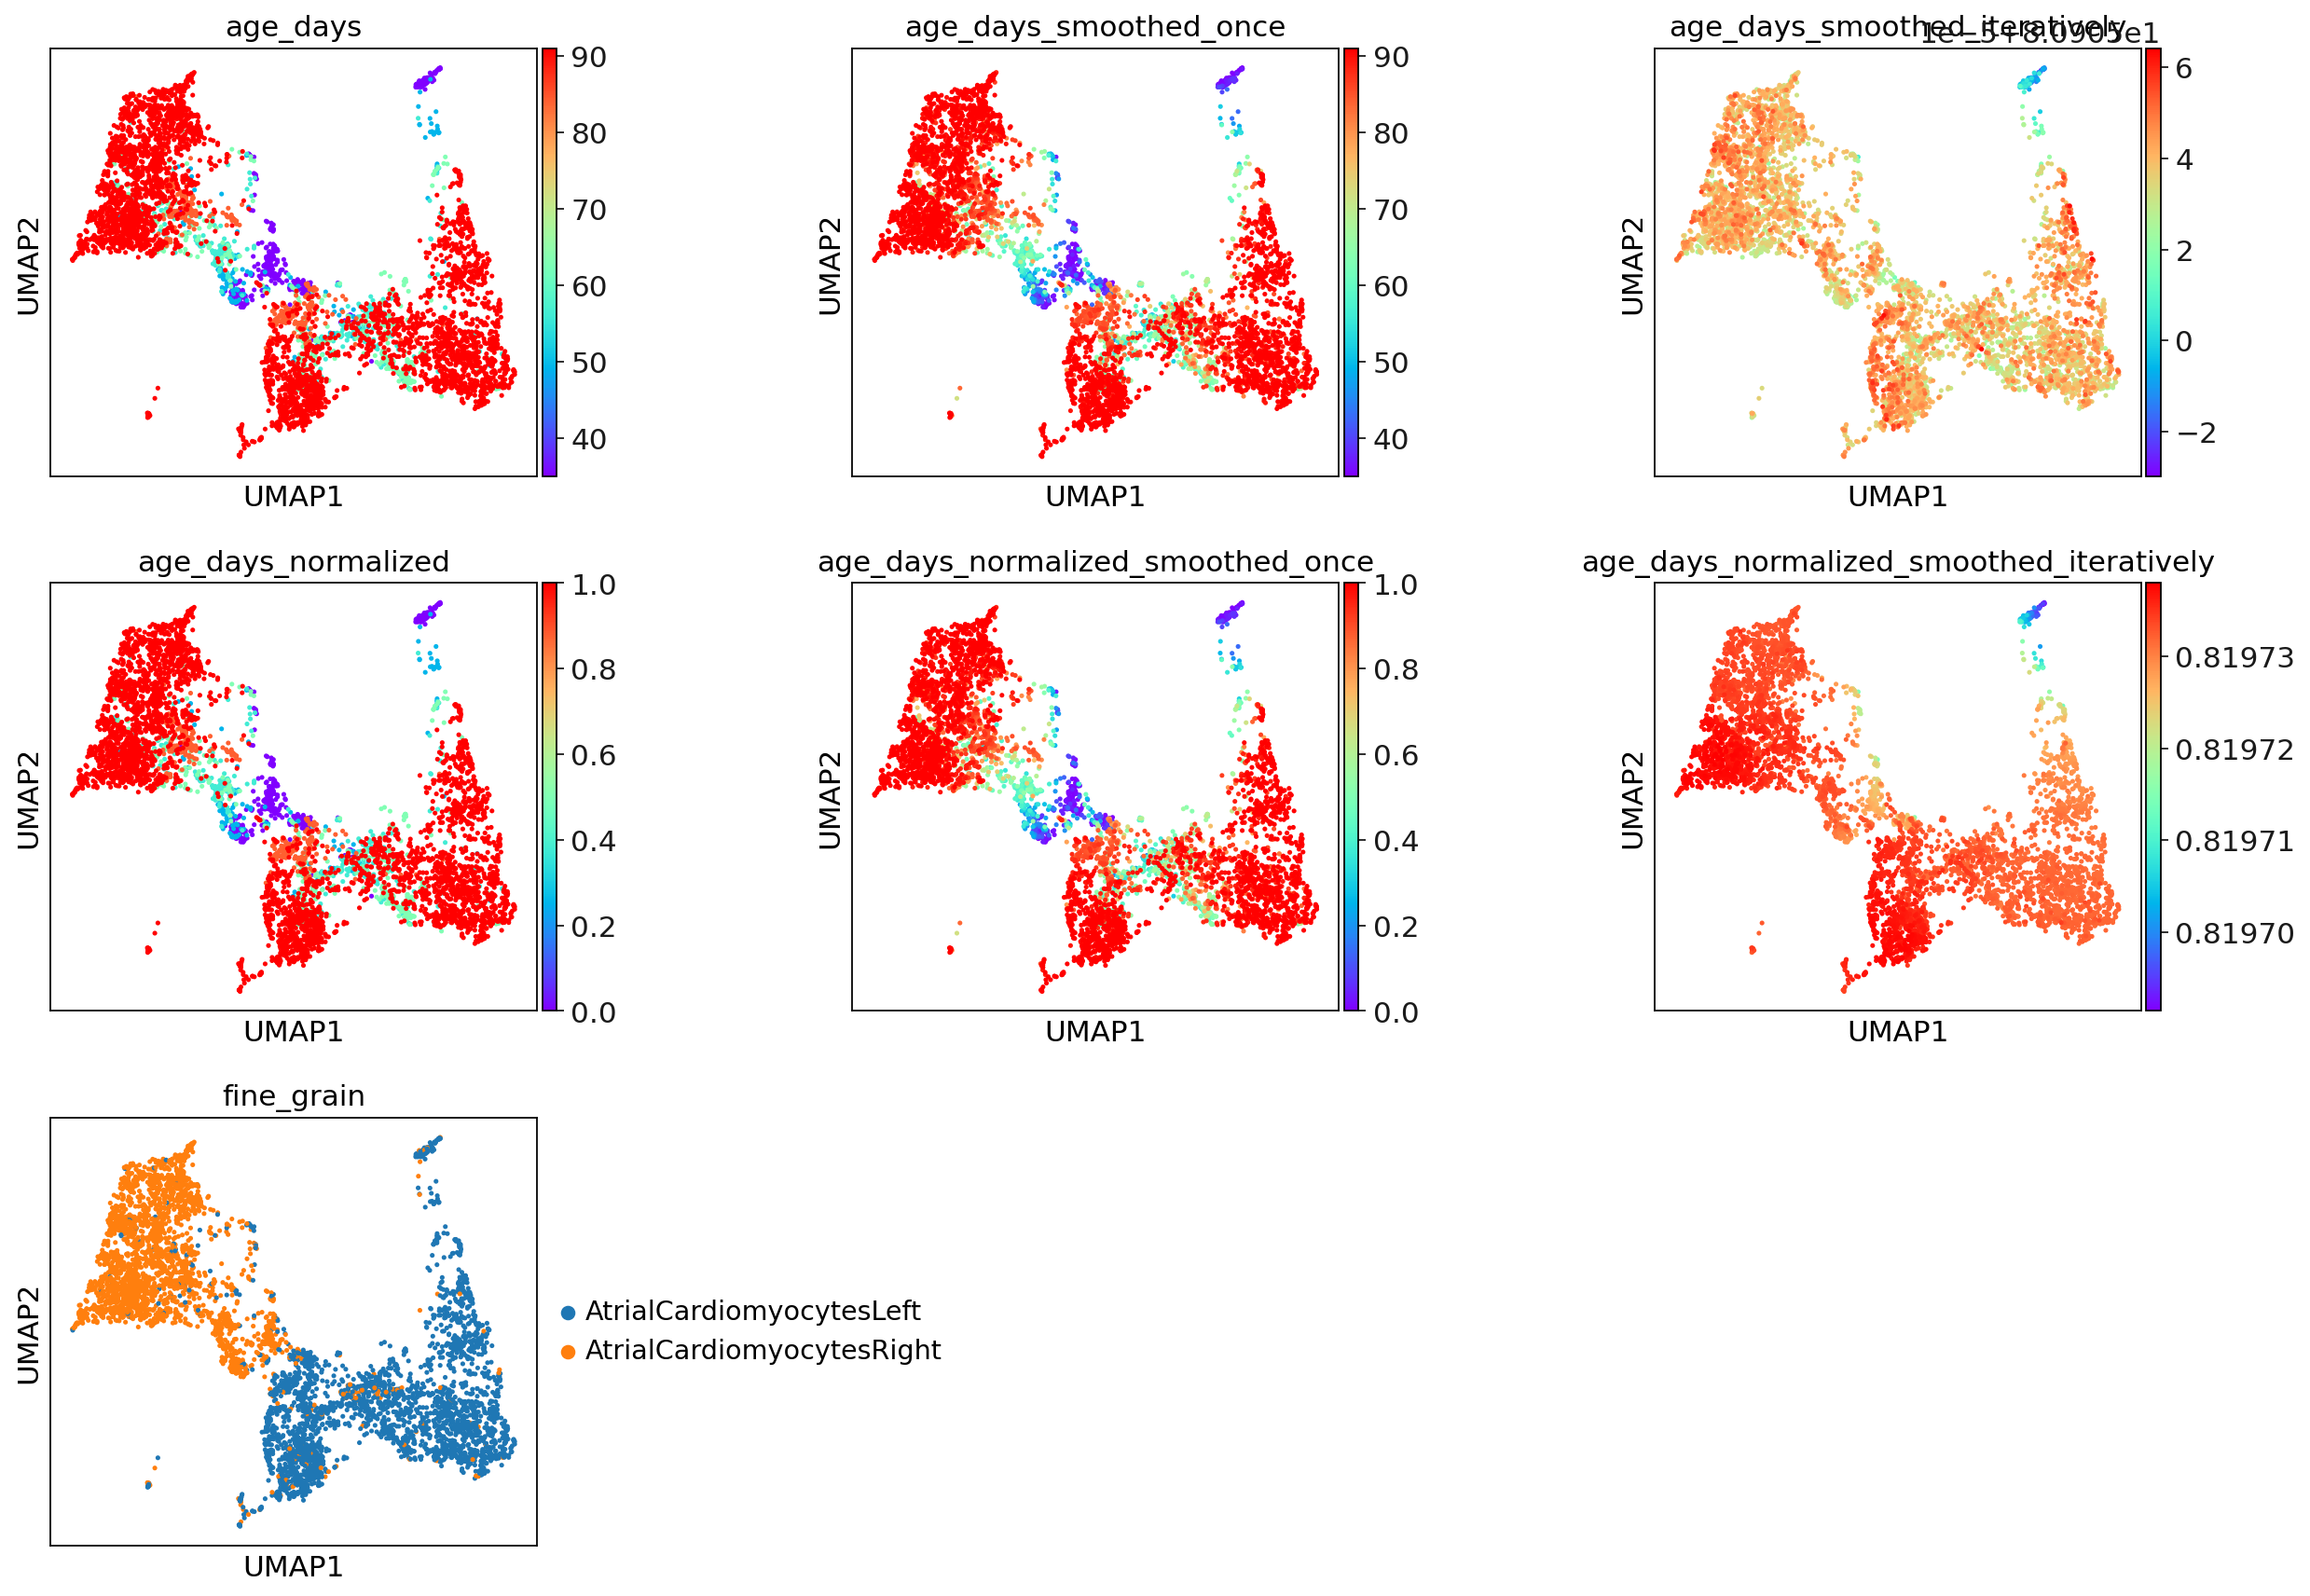

In [26]:
sc.pl.umap(adata,color=["age_days","age_days_smoothed_once","age_days_smoothed_iteratively",
                        "age_days_normalized","age_days_normalized_smoothed_once","age_days_normalized_smoothed_iteratively",
                        "fine_grain"],
           cmap='rainbow',wspace=0.5,ncols=3)

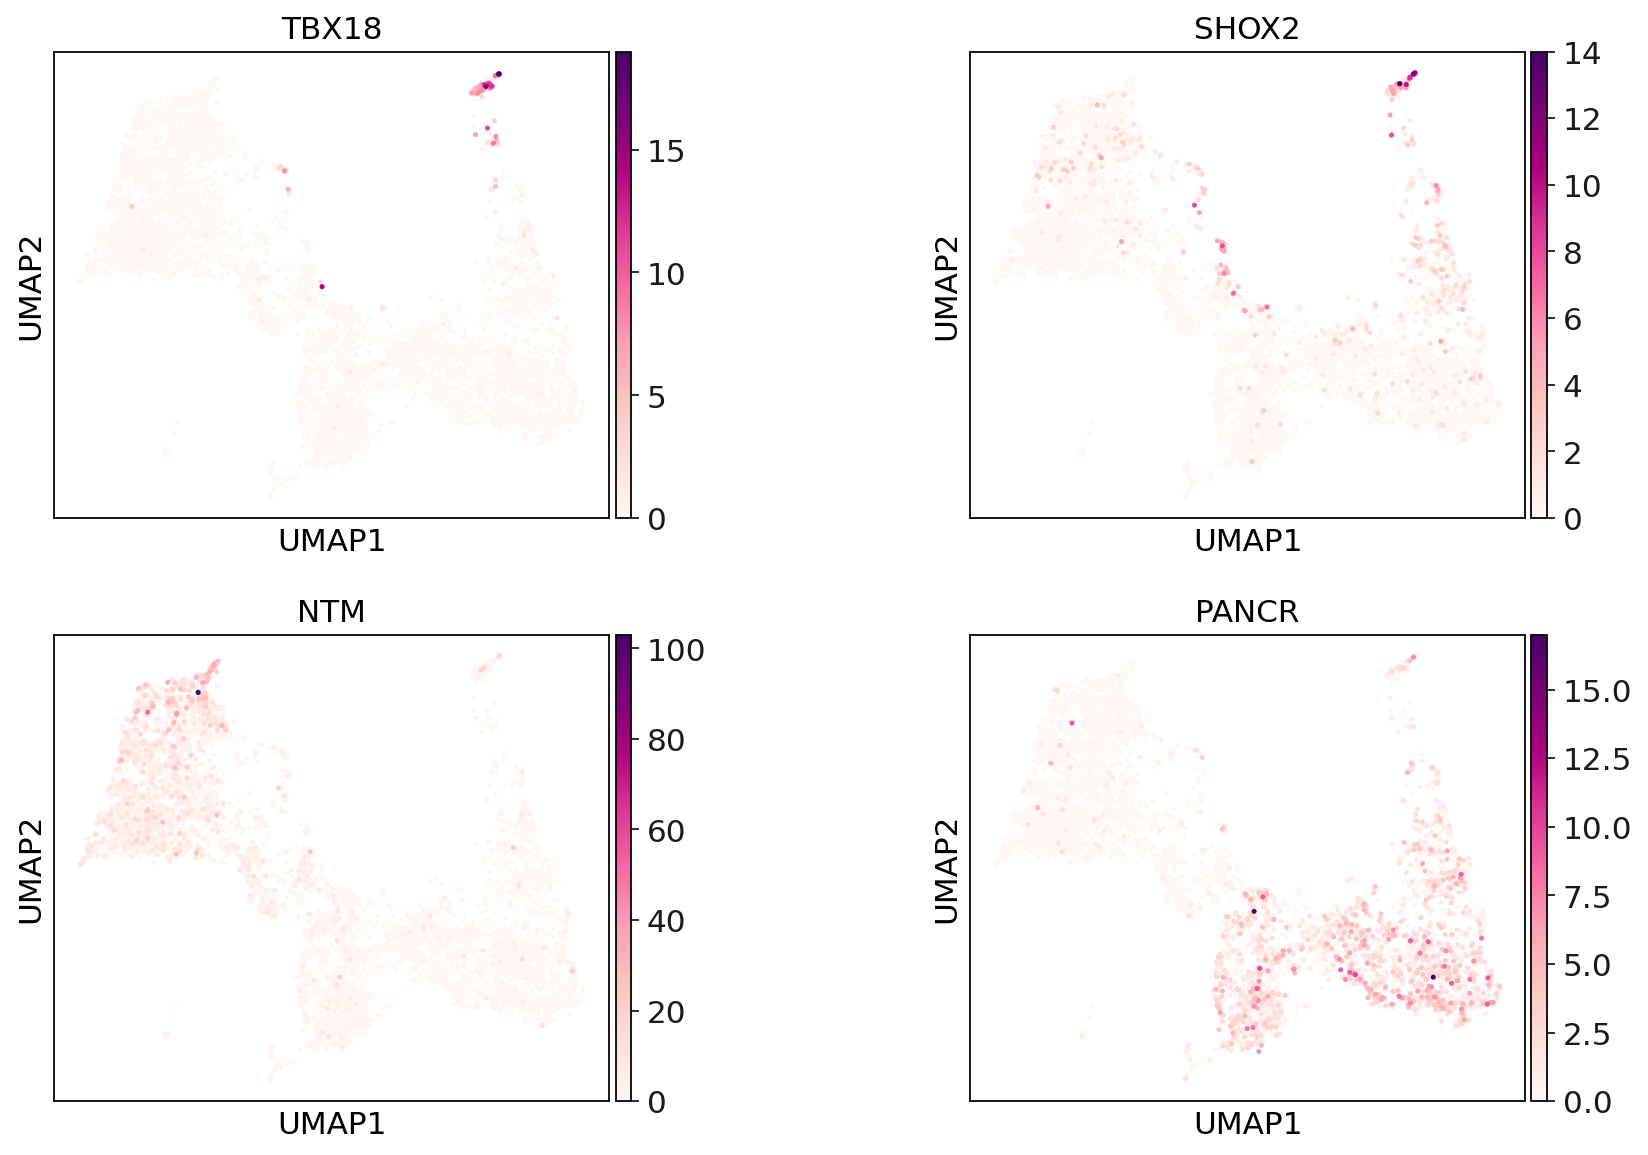

In [27]:
sc.pl.umap(adata,color=["TBX18","SHOX2","NTM","PANCR"],cmap='RdPu',wspace=0.5,ncols=2)

In [28]:
temporal_ordering="age_days_smoothed_iteratively"

# scVI

In [29]:
global_adata = sc.read('/nfs/team205/heart/anndata_objects/Foetal/Feb28ObjectRaw.h5ad')
global_adata

AnnData object with n_obs × n_vars = 297473 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score'
    var: 'gene_name_scRNA-0', 'gene_id'
    uns: 'FACSgate_colors', '_scvi_manager_uuid', '_scvi_uuid', 'age_colors', 'cell_or_nucl

In [31]:
# Grab scVI latent variables for just the cells in adata
adata.obsm["X_scVI"] = global_adata[global_adata.obs.index.isin(adata.obs.index)].obsm["X_scVI"].copy()

# Palantir

In [39]:
# projectsions from scVI
projections = pd.DataFrame(adata.obsm["X_scVI"],index=adata.obs_names)

In [40]:
# fate probability mapping of the cells
dm_res = palantir.utils.run_diffusion_maps(projections)
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=4)

Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [41]:
# Generate embedding from the multiscale diffusion space
adata.obsm["X_palantirscVI"]=ms_data.values

In [35]:
def plot_and_store(init_pos, adata):
    """
    This function selects the columns of the obsm layer specified by init_pos, 
    draws a graph using these coordinates as the initial positions, and stores the graph 
    coordinates in a new obsm layer named 'X_draw_graph_fa_' followed by the value of init_pos. 
    The modified AnnData object is then returned.

    If adata.obsm[f'X_draw_graph_fa_{init_pos}'] already exists, it puts that in adata.obsm['X_draw_graph_fa'].
    If adata.obsm[f'X_draw_graph_fa_{init_pos}'] does not exist, it performs sc.tl.draw_graph() as before.

    Parameters
    ----------
    init_pos : str
        Initial position for the graph. Should be in the format 'X_palantir12'.
    
    adata : AnnData
        The annotated data matrix of shape n_obs x n_vars. Rows correspond
        to cells and columns to genes.

    Returns
    -------
    adata : AnnData
        The modified annotated data matrix.
    """
    x_col = int(init_pos[-2:][0]) - 1
    y_col = int(init_pos[-2:][1]) - 1
    selected_cols = [x_col, y_col]
    adata.obsm[f'{init_pos}'] = adata.obsm[f'{init_pos[:-2]}'][:,selected_cols]
    
    if f'X_draw_graph_fa_{init_pos}' in adata.obsm:
        print(f'graph using {init_pos} has previously been calculated, retrieving that...')
        adata.obsm['X_draw_graph_fa'] = adata.obsm[f'X_draw_graph_fa_{init_pos}']
    else:
        print('calculating graph coordinates...')
        sc.tl.draw_graph(adata,init_pos=init_pos)
        adata.obsm[f'X_draw_graph_fa_{init_pos}'] = adata.obsm['X_draw_graph_fa'].copy()
    return adata

In [36]:
adata

AnnData object with n_obs × n_vars = 5664 × 544641
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', 'age_days', 'age_days_smoothed_once', 'age_days_normalized', 'age_days_normalized_smoothed_once', 'age_days_smoothed_iteratively', 'age_days_normalized_smoothed_iteratively'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id'
    uns: 'neighbors', 'umap', 'fine_grain_colors', 'week_colors', 'donor_colors'
    obsm: 'X_multiVI', '

X_umap12
graph using X_umap12 has previously been calculated, retrieving that...


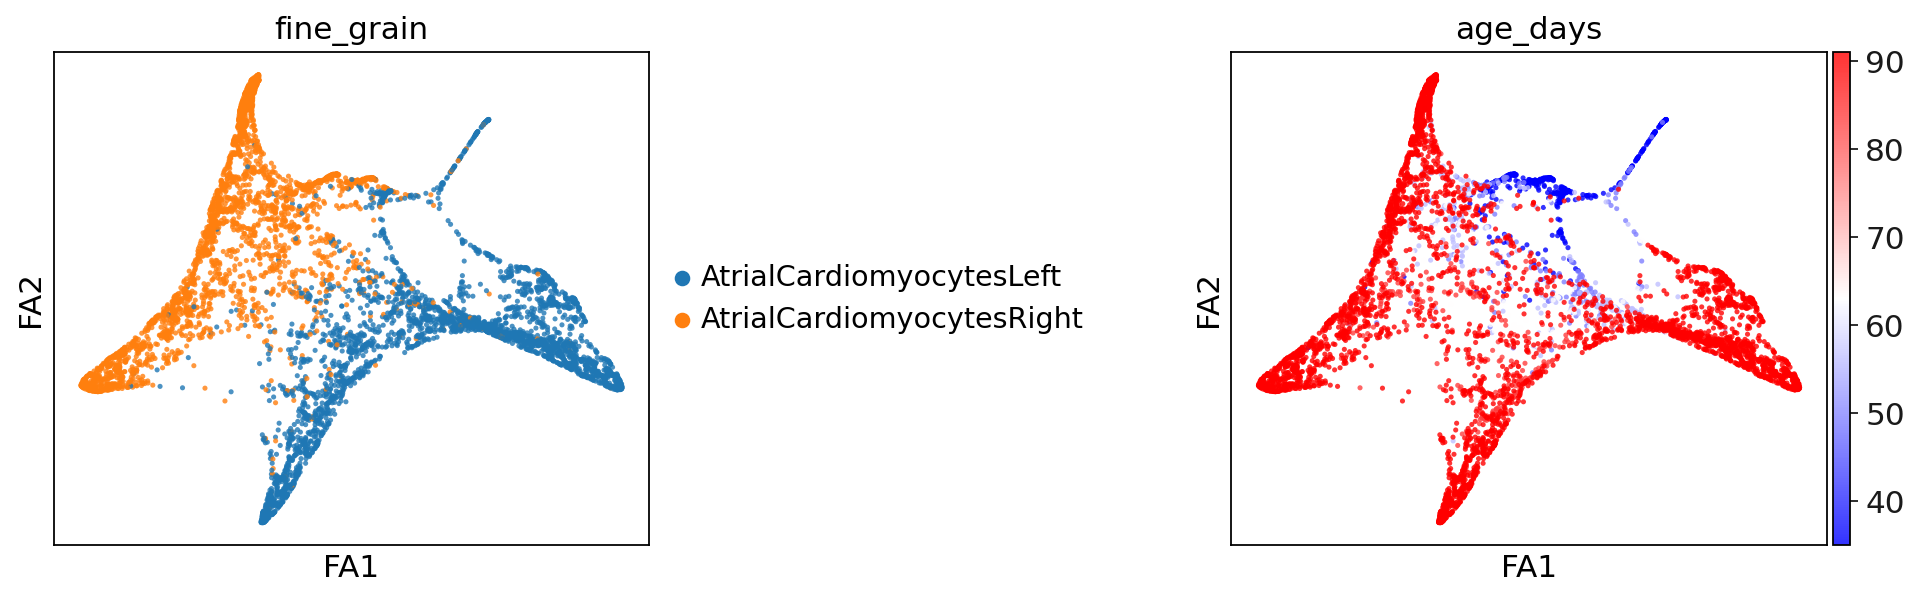

X_umap13
graph using X_umap13 has previously been calculated, retrieving that...


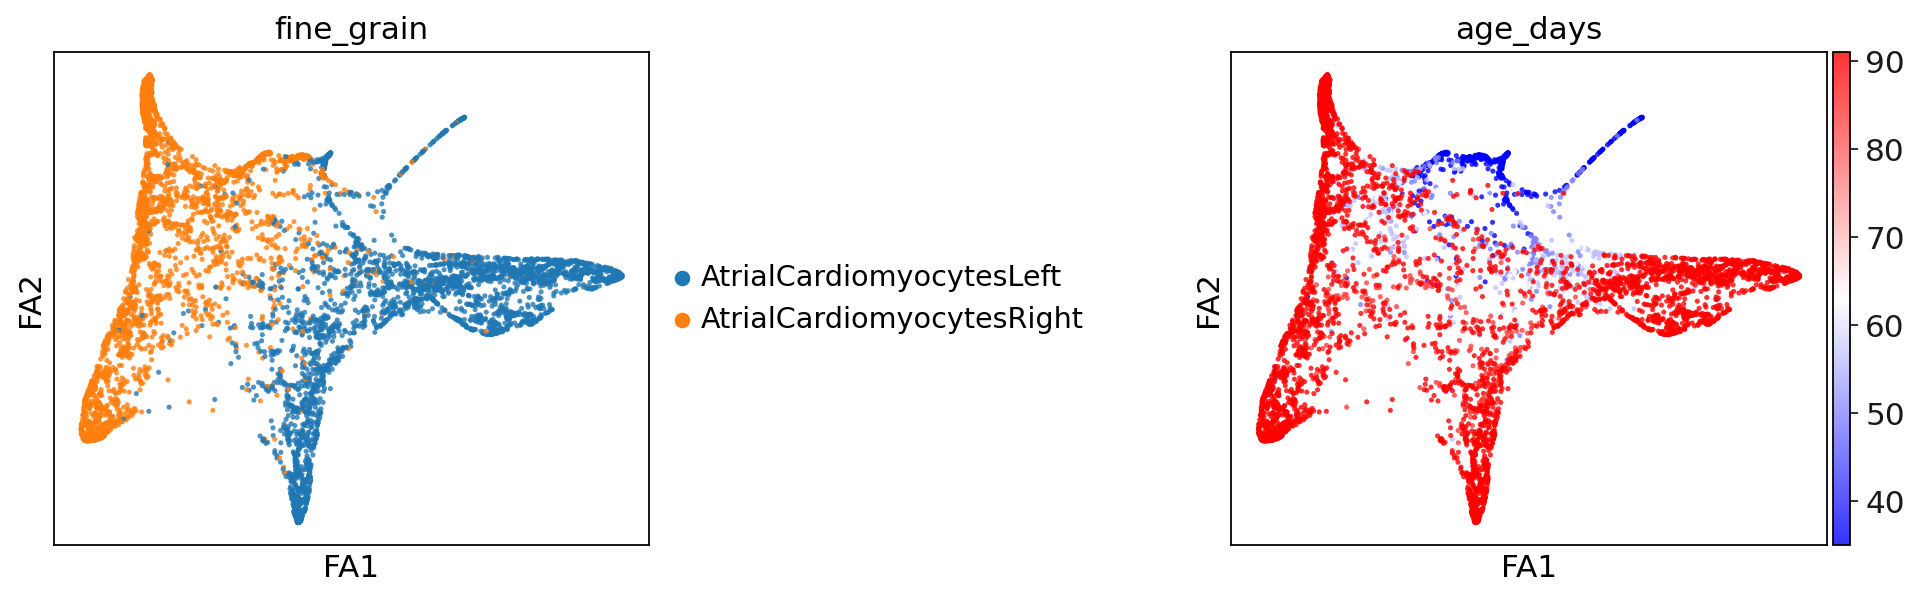

X_palantir12
graph using X_palantir12 has previously been calculated, retrieving that...


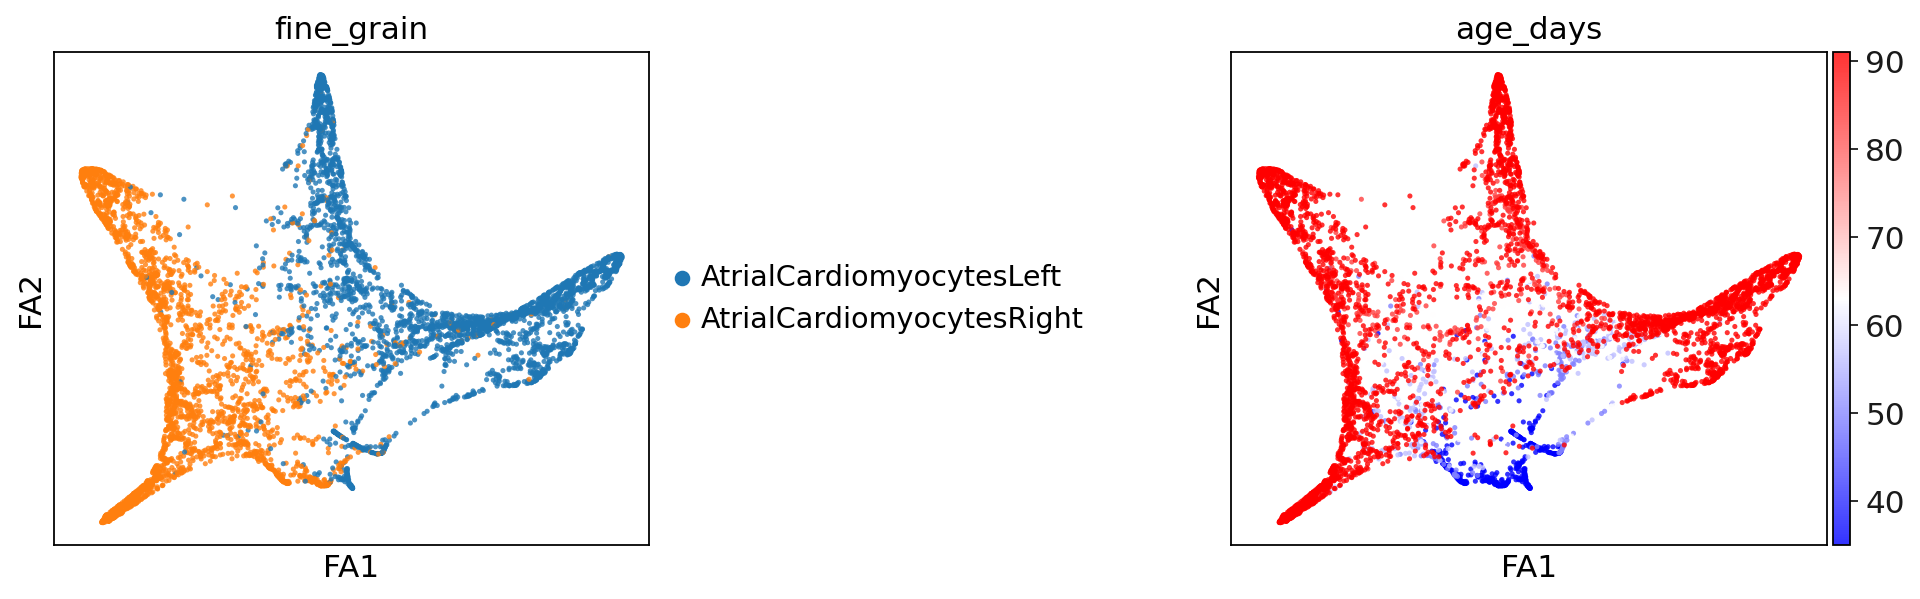

X_palantir13
graph using X_palantir13 has previously been calculated, retrieving that...


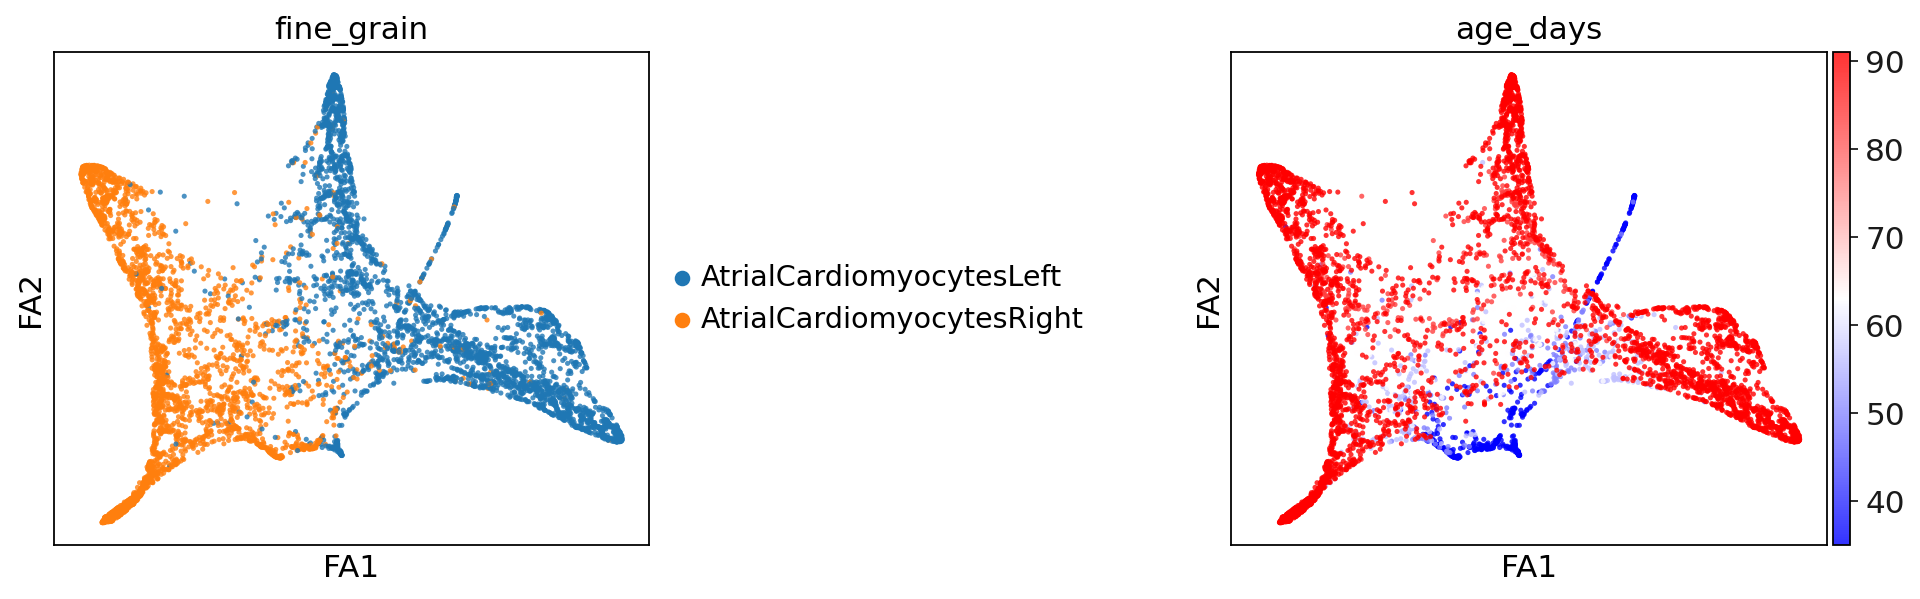

X_scVI12
graph using X_scVI12 has previously been calculated, retrieving that...


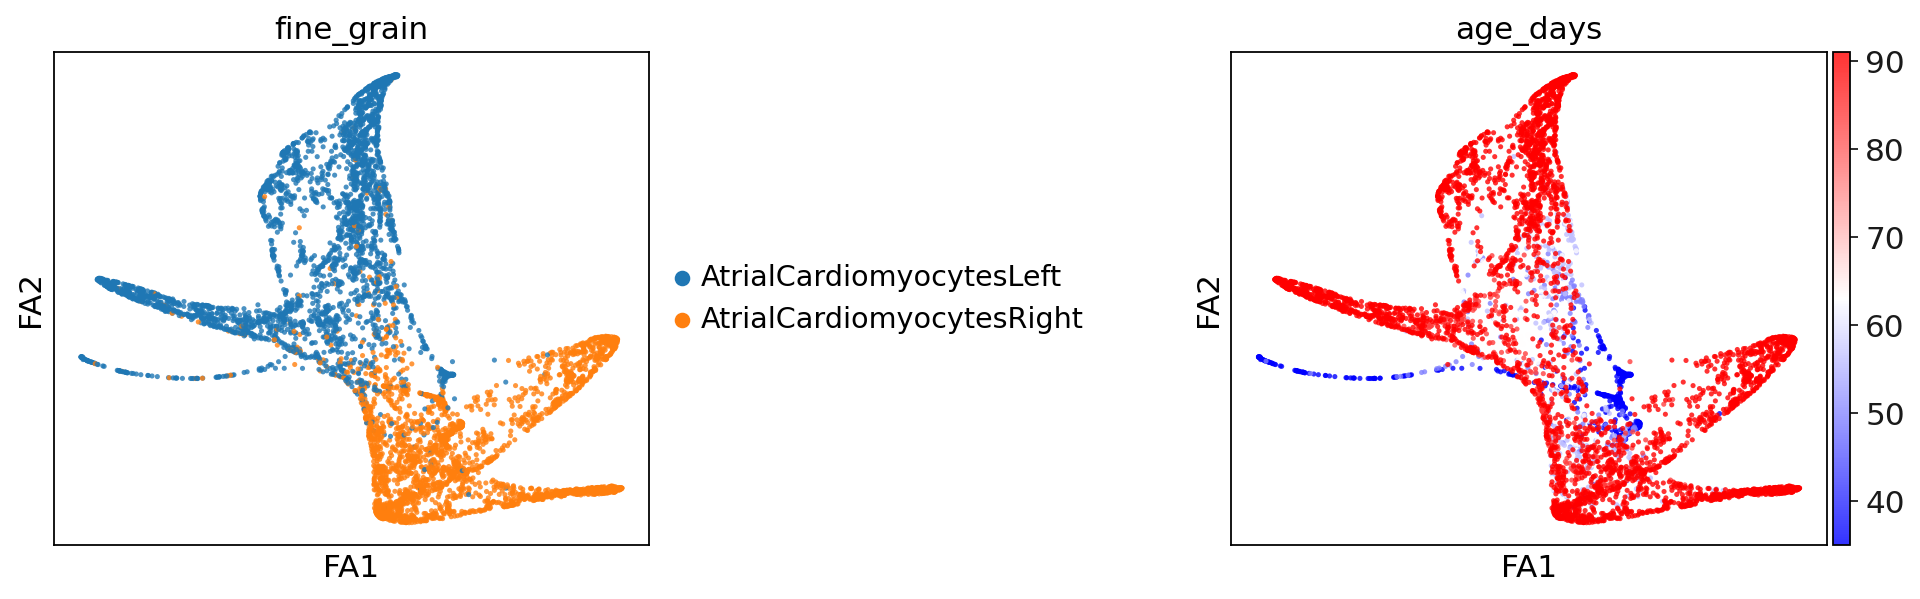

X_scVI13
graph using X_scVI13 has previously been calculated, retrieving that...


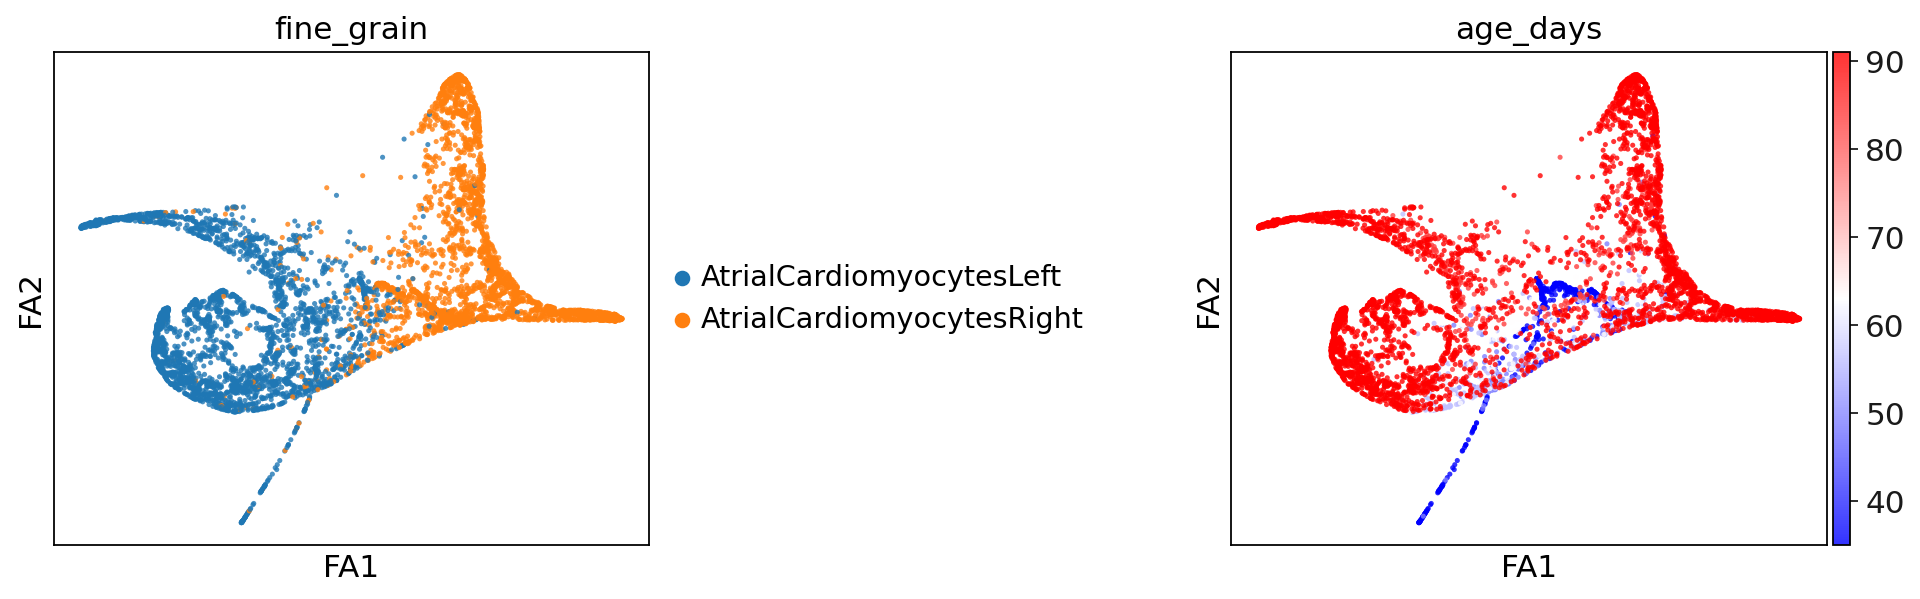

X_palantirscVI12
calculating graph coordinates...
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:34)


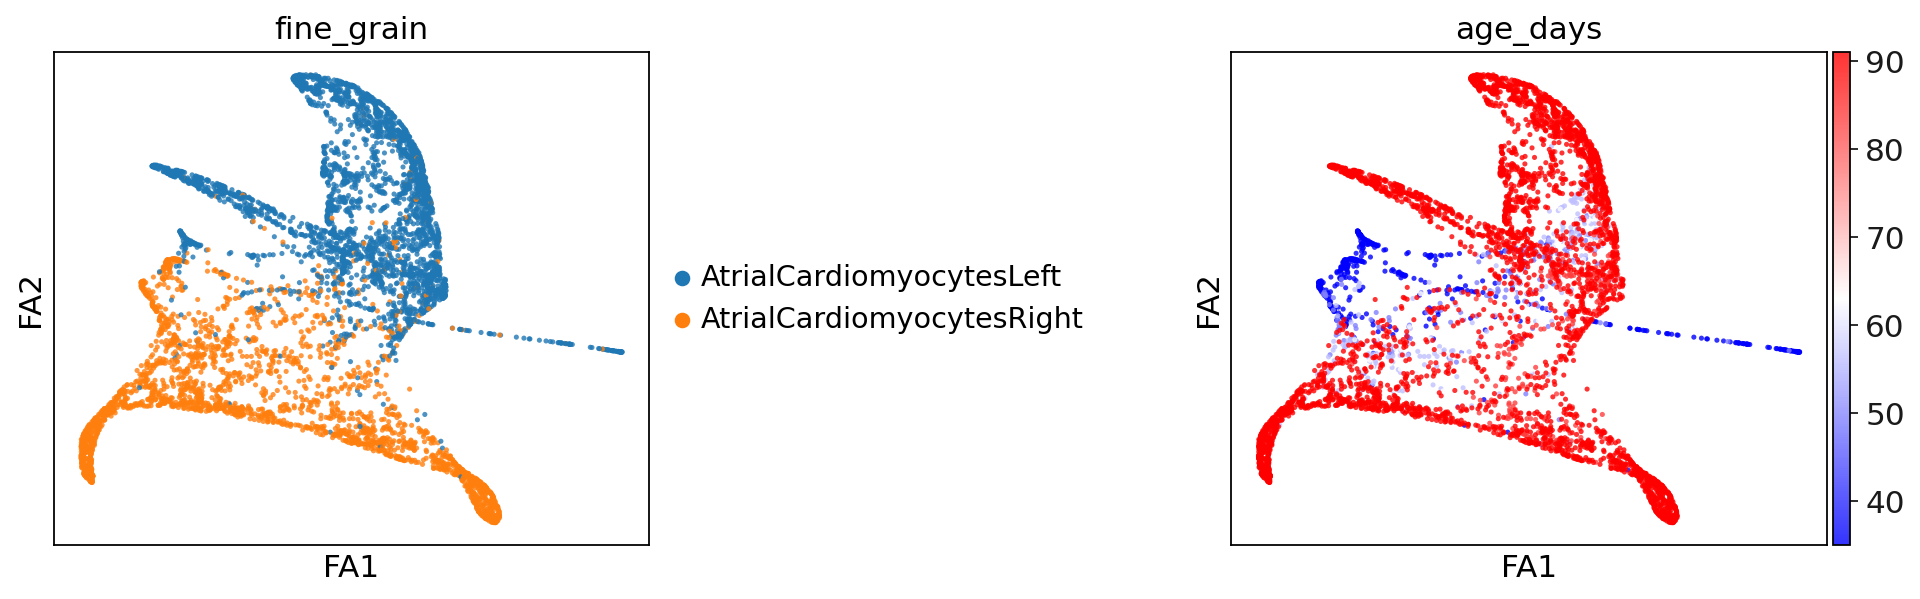

X_palantirscVI13
calculating graph coordinates...
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:33)


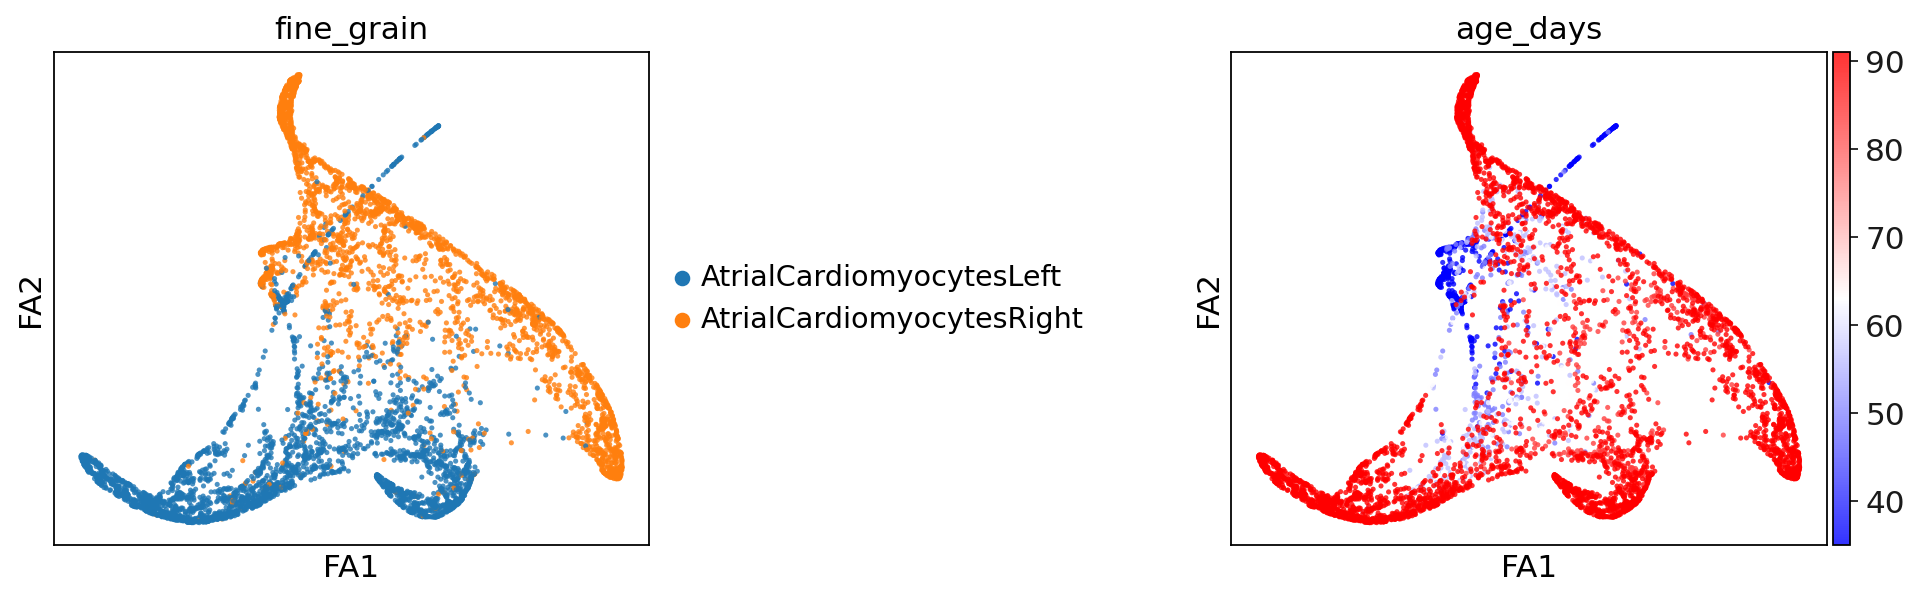

CPU times: user 1min 4s, sys: 3.06 s, total: 1min 7s
Wall time: 1min 15s


In [42]:
%%time
embeddings=['X_umap12','X_umap13','X_palantir12','X_palantir13', 'X_scVI12','X_scVI13','X_palantirscVI12','X_palantirscVI13']

for embedding in embeddings:
        print(embedding)
        adata = plot_and_store(embedding, adata)
        sc.pl.draw_graph(adata,color=['fine_grain','age_days'],wspace=0.8, ncols=2,cmap='bwr', alpha=0.8)

### Pseudotime - scFates

inferring a principal tree --> parameters used 
    50 principal points, sigma = 0.4, lambda = 10000, metric = euclidean
    fitting:   5%|█████████▎                                                                                                                                                                                 | 10/200 [00:01<00:21,  8.81it/s]
    converged
    finished (0:00:01) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


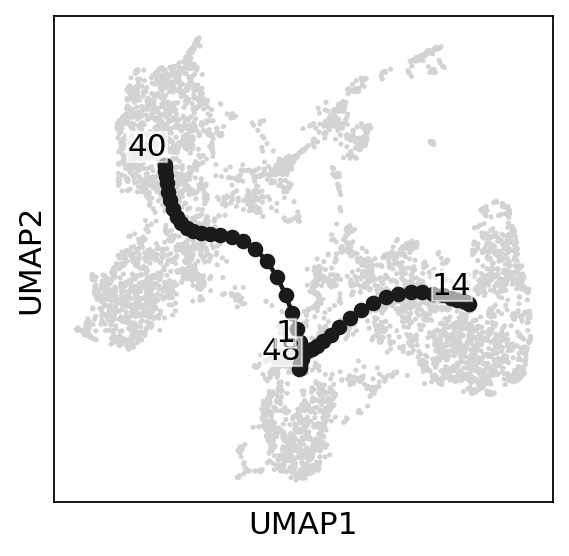

In [46]:
scf.tl.tree(adata,method="ppt",Nodes=50,use_rep="umap",
            device="cpu",seed=1,ppt_lambda=10000,ppt_sigma=0.4,ppt_nsteps=200)

scf.pl.graph(adata)

In [30]:
scf.tl.root(adata,49)

node 49 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [31]:
scf.tl.pseudotime(adata,n_jobs=20,n_map=100,seed=42)

projecting cells onto the principal graph
    mappings:   0%|                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

Unable to determine R library path: Command '('/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scfates_env/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scfates_env/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scfates_env/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scfates_env/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scfates_env/lib/R/bin/Rscript', '-e', 'cat(Sy

    mappings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.93it/s]
    finished (0:00:57) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


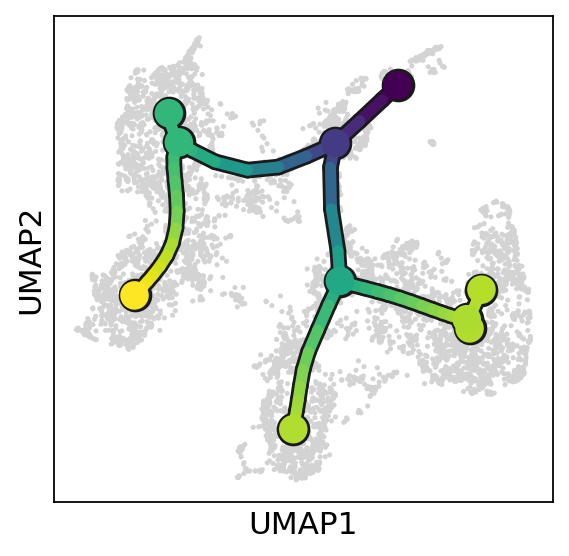

In [32]:
scf.pl.trajectory(adata)

# Compare real and pseudo-time

In [34]:
temporal_ordering='age_days_smoothed_once'

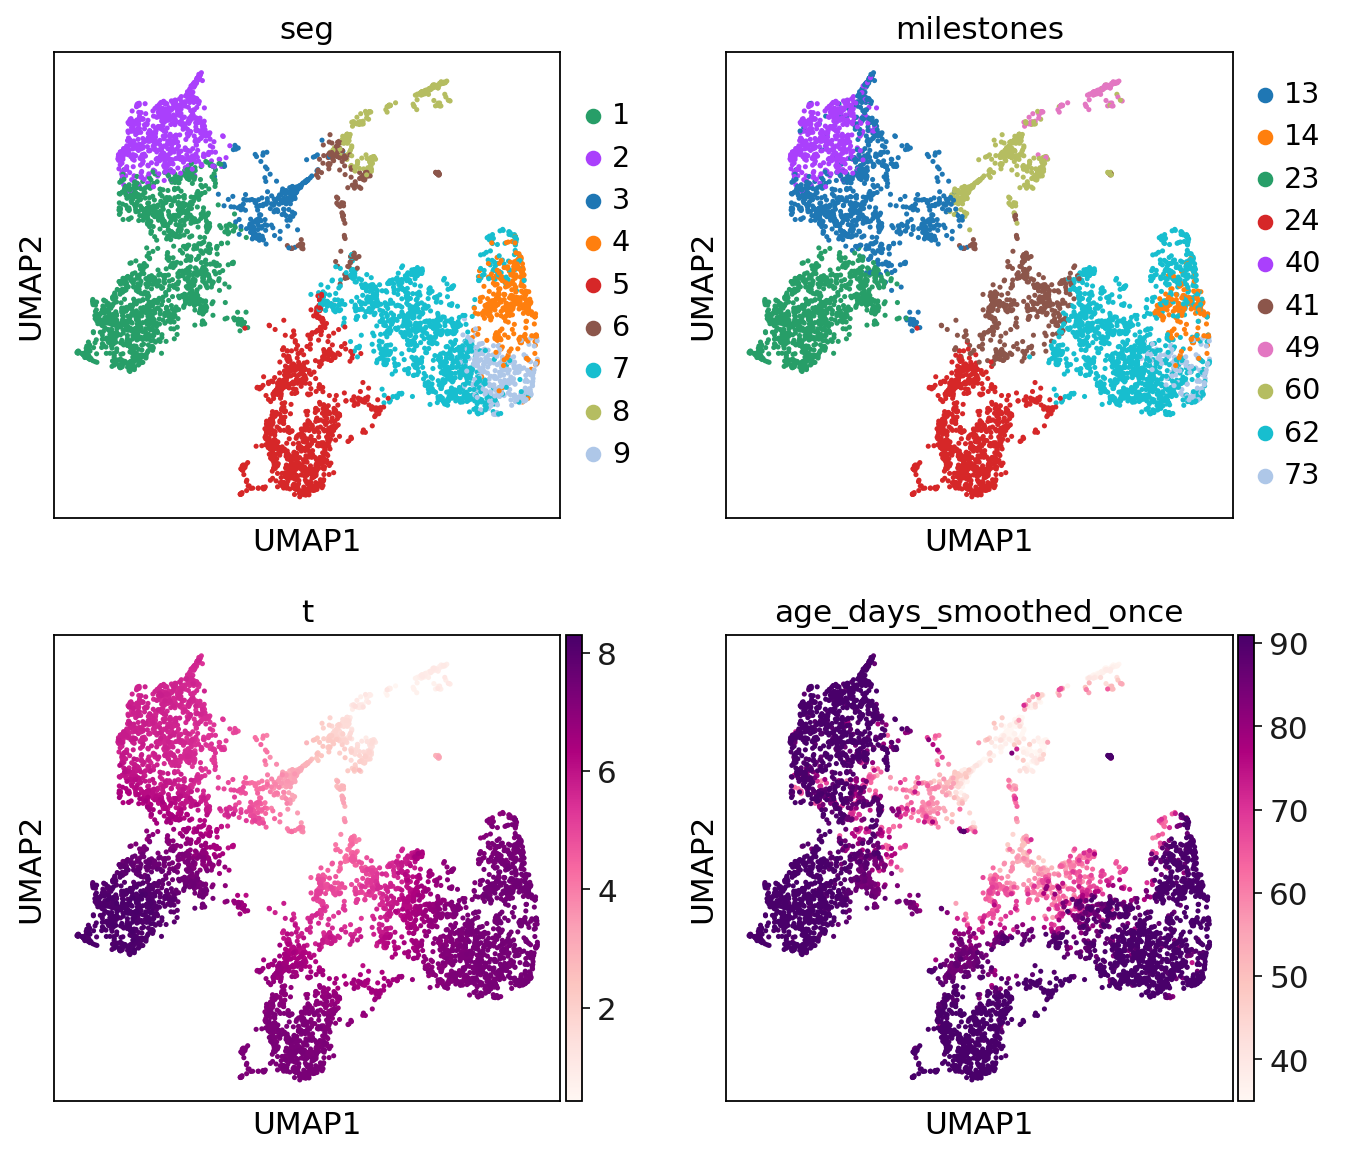

In [35]:
sc.pl.umap(adata,color=["seg","milestones","t",temporal_ordering],ncols=2)

(0.8275538981212454, 0.0)

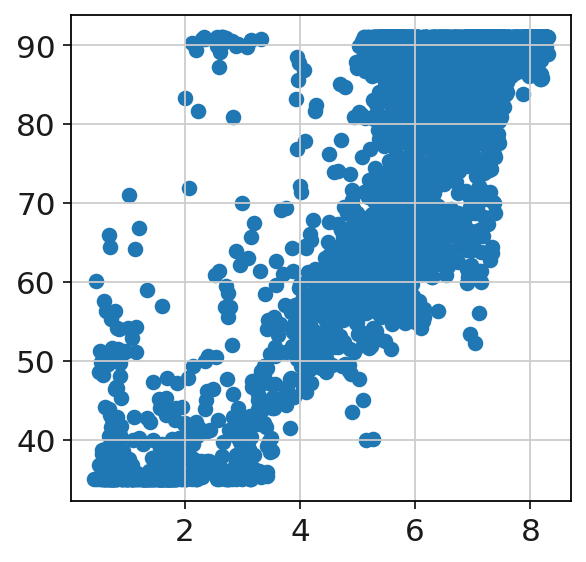

In [36]:
import scipy.stats

# Assuming `adata` is your AnnData object and it has 't' and 'x' in its obs DataFrame
t_values = adata.obs['t']
x_values = adata.obs[temporal_ordering]

# Calculate the Pearson correlation coefficient and the p-value
correlation_coefficient, p_value = scipy.stats.pearsonr(t_values, x_values)

plt.scatter(t_values,x_values)
correlation_coefficient, p_value

<Axes: xlabel='age_days', ylabel='Count'>

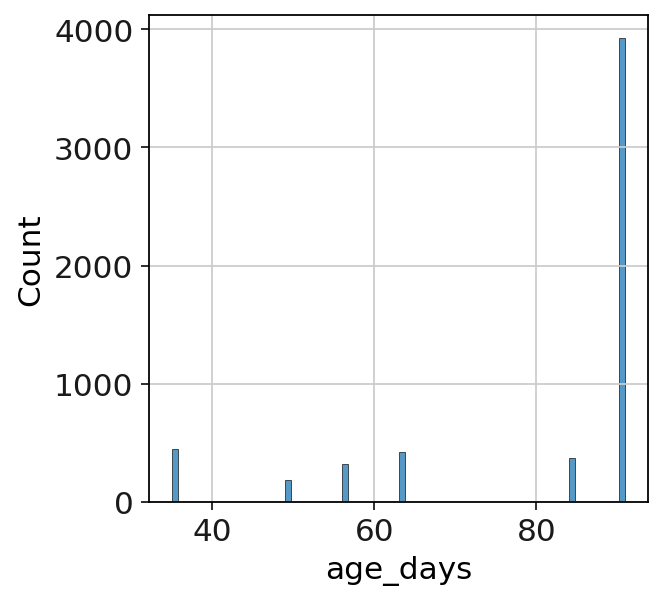

In [37]:
import seaborn as sns
sns.histplot(adata.obs.age_days)

<Axes: xlabel='age_days_smoothed_once', ylabel='Count'>

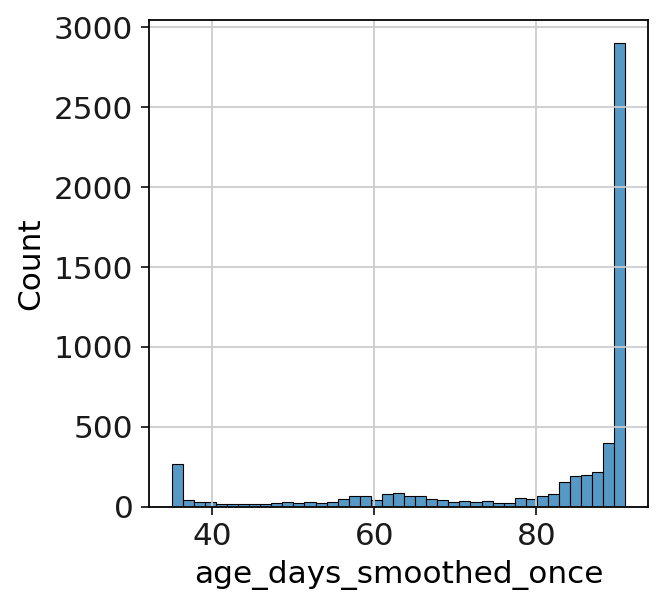

In [38]:
sns.histplot(adata.obs[temporal_ordering])

<Axes: xlabel='t', ylabel='Count'>

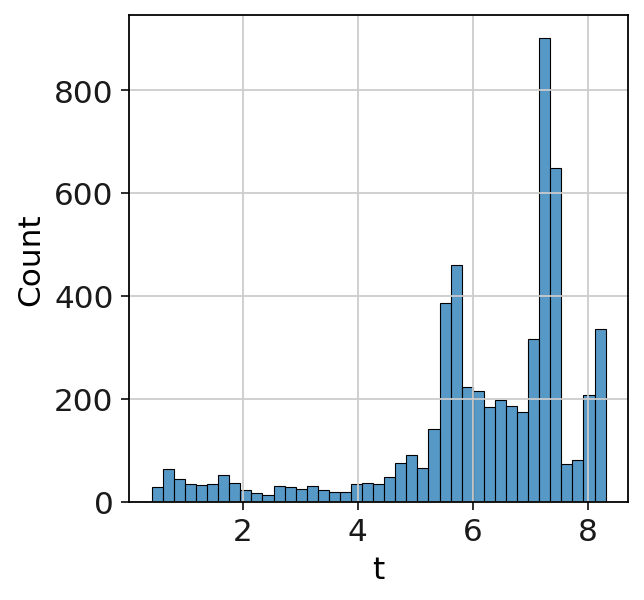

In [39]:
sns.histplot(adata.obs['t'])

# Save object with UMAP, time and pseudotiem computed

In [41]:
paired_adata_with_time_path = "/lustre/scratch126/cellgen/team205/heart/objects/fetal/RNA/aCMs_WholeSample_paired_with_time.h5ad"
adata.write(paired_adata_with_time_path)
adata

AnnData object with n_obs × n_vars = 5664 × 544641
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', 'age_days', 'age_days_smoothed_once', 'age_days_normalized', 'age_days_normalized_smoothed_once', 'age_days_smoothed_iteratively', 'age_days_normalized_smoothed_iteratively', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id'
    uns: 'neighbors', 'umap', 'fine_grain_colors', 'week_colors